# Attempt to mimic stochastic gradient descent to tune hyperparameters
## Assumptions
* KFold cross validation is valid (no shuffling)
* loss function is somewhat smooth

## Data and Imports

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import loguniform
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_validate, train_test_split
# from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')

In [3]:
train_data = pd.read_csv(
    "/kaggle/input/tabular-playground-series-may-2022/train.csv",
)
train_target = train_data.target.copy()
train_data.drop(columns=["id", "target"], inplace=True)

`f_27` is categorical: 10-letter strings. Split into 10 new features and ordinarily encode each.

In [4]:
print(train_data.f_27[0])
print(train_data.f_27.nunique())

ABABDADBAB
741354


In [5]:
new_features = pd.DataFrame(
    np.concatenate(
        train_data.f_27.apply(lambda x: [sym for sym in x]).values, axis=0
    ).reshape(-1, 10),
    columns = [f"f_27_{x}" for x in range(10)]
)

In [6]:
train_data = pd.concat(([train_data, new_features]), axis=1)
train_data.drop(columns="f_27", inplace=True)

## Model and Initial Cross Validation

In [7]:
cat_processor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
preprocessor = ColumnTransformer(
    [("OrdinalEncoder", cat_processor, [f"f_27_{x}" for x in range(10)])],
    remainder="passthrough"
)
estimator = HistGradientBoostingClassifier(
    max_iter=200, early_stopping=True, random_state=1)

model = make_pipeline(preprocessor, estimator)

For a reference, the best configuration found with a few iterations of `RandomizedSearchCV`:

| l2_regularization | learning_rate | max_leaf_nodes | min_samples_leaf | mean_test_score | std_test_score |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 0.244505 | 0.182073 | 98 | 29 | 0.900514 | 0.000727 | 

In [8]:
cv_results = cross_validate(
    model, train_data, train_target, scoring=["accuracy", "neg_log_loss"],
    return_train_score=True,cv=5, n_jobs=3, verbose=2
)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  6.2min remaining:  4.2min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 10.2min finished


In [9]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_accuracy,train_accuracy,test_neg_log_loss,train_neg_log_loss
0,181.240980,36.080131,0.879733,0.883946,-0.315339,-0.310522
1,185.642151,35.868310,0.879544,0.884015,-0.316894,-0.310150
2,188.020490,36.305061,0.881489,0.883829,-0.314538,-0.310547
3,124.107308,24.041929,0.880306,0.883151,-0.316781,-0.311862
4,122.414650,24.366933,0.880161,0.883422,-0.316961,-0.311291


## Hyperparameter Tuning
### Data Batch Generator

In [10]:
def feed_batch(data, size=10000):
    """Sequentially yields batches of passed data in batches of the specified size"""
    for i in range(0, data.shape[0], size):
        try:
            batch = data.iloc[i : i + size].copy()
        except:
            batch = data.iloc[i:].copy()
        yield batch

A quick test of `feed_batch` function.

In [11]:
data_generator = feed_batch(train_data[-23000:], size=8000)
target_generator = feed_batch(train_target[-23000:], size=8000)

for _ in range(4):
    try:
        test_batch_data = next(data_generator)
        test_batch_target = next(target_generator)
        model.fit(test_batch_data[:6000], test_batch_target[:6000])
        print(model.score(test_batch_data[6000:], test_batch_target[6000:]))
        print("")
    except StopIteration:
        print("Ops")

0.83

0.8235

0.825

Ops


### Hyperparameter Update Functions
Akin to partial differentiation, every batch of data will be used to:

0. get a baseline metric (a loss function) with the current hyperparameters,
1. adjust sequentially each hyperparameter and record the resultant change in loss function,
2. based on the change, update the hyperparameters and set them to the model,
3. repeat steps 0-2 on every batch (thus, completing one epoch).

The challenge is that an update function must be specifically tailored to a hyperparameter, as some are restricted to`int` type, and others may have an enormous range of valid values (e.g., param ∈ $\mathbb{R}$).

In [12]:
def update_int_param(cur_val, min_val=4, max_val=256, by=2):
    # ensure return is int and within the interval
    new_val = max([round(cur_val + by), min_val])
    return min([new_val, max_val])

def update_log_param(cur_val, min_val=1e-3, max_val=1e3, by=5e-3):
    cur_p = loguniform.cdf(cur_val, min_val, max_val)
    if ((cur_p - by) < 0) | ((cur_p + by) > 1):
        return cur_val
    return loguniform.ppf(cur_p + by, min_val, max_val)

The initial idea is to change by a small value and then change it by the same value in a direction of loss decrease. A more aggressive approach might be needed though.

In [13]:
print(loguniform.cdf(50,1,100))  # current procentile (~84.95%)
print(loguniform.ppf(.80,1,100))  # 80th procentile value (i.e., decrease by 4.95%)
print(loguniform.cdf(39.810717055349734,1,100))

0.8494850021680093
39.810717055349734
0.7999999999999999


In [14]:
model.set_params(histgradientboostingclassifier__l2_regularization=1e-2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['f_27_0', 'f_27_1', 'f_27_2',
                                                   'f_27_3', 'f_27_4', 'f_27_5',
                                                   'f_27_6', 'f_27_7', 'f_27_8',
                                                   'f_27_9'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                l2_regularization=0.01,
                                                max_iter=200,
                                                random_state=1))])

In [15]:
param_update_funcs = {
    'histgradientboostingclassifier__l2_regularization': update_log_param,
    'histgradientboostingclassifier__learning_rate': update_log_param,
    'histgradientboostingclassifier__max_leaf_nodes': update_int_param,
    'histgradientboostingclassifier__min_samples_leaf': update_int_param,
}

In [16]:
def batch_train(
    model, batch_data, batch_target, param_update_funcs
):
    # data split, initial fit and score
    X_train, X_test, y_train, y_test = train_test_split(
        batch_data, batch_target, shuffle=False)
    model.fit(X_train, y_train)
    loss = log_loss(y_test, model.predict(X_test))

    # initiate log
    params_log = np.array(
        [[model.get_params()[key] for key in param_update_funcs.keys()]])
    loss_log = [loss]

    # forward pass
    for param, update_func in param_update_funcs.items():
        cur_val = model.get_params()[param]
        new_val = update_func(cur_val)  # "step" increase
        model.set_params(**{param: new_val})
        model.fit(X_train, y_train)
        loss = log_loss(y_test, model.predict(X_test))

        # log entry
        params_log = np.append(
            params_log,
            np.array(
                [[model.get_params()[key] for key in param_update_funcs.keys()]]),
            axis=0)
        loss_log.append(loss)

        # return to the original parameter value
        model.set_params(**{param: cur_val})
    
    log = pd.DataFrame(params_log, columns=param_update_funcs.keys())
    log["test_loss"] = loss_log

    return log

In [17]:
log = batch_train(model, test_batch_data, test_batch_target, param_update_funcs)
log.rename(columns={item:item.split("__")[-1] for item in log.columns})

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,test_loss
0,0.010000,0.100000,31.0,20.0,5.960472
1,0.010715,0.100000,31.0,20.0,6.355210
2,0.010000,0.107152,31.0,20.0,6.098631
3,0.010000,0.100000,33.0,20.0,6.355206
4,0.010000,0.100000,31.0,22.0,5.920998


In [18]:
def update_params(log, param_update_funcs):
    d_losses = log["test_loss"][1:] - log["test_loss"][0]
    new_params = {}
    for i, dl in enumerate(d_losses):
        if np.allclose(0, dl):
            new_params[log.iloc[:, i].name] = log.iloc[:, i][0]
#             continue  # go to next iteration
        elif dl < 0:
            new_params[log.iloc[:, i].name] = \
            param_update_funcs[log.iloc[:, i].name](log.iloc[0, i])
#             log.iloc[:, i][0] + log.iloc[:, i].diff().max()
        else:
            new_by = - param_update_funcs[log.iloc[:, i].name].__defaults__[-1]
            new_params[log.iloc[:, i].name] = \
            param_update_funcs[log.iloc[:, i].name](log.iloc[0, i], by=new_by)
#             log.iloc[:, i][0] - log.iloc[:, i].diff().max()
    return new_params

In [19]:
new_params = update_params(log, param_update_funcs)
new_params

{'histgradientboostingclassifier__l2_regularization': 0.009332543007969912,
 'histgradientboostingclassifier__learning_rate': 0.09332543007969915,
 'histgradientboostingclassifier__max_leaf_nodes': 29,
 'histgradientboostingclassifier__min_samples_leaf': 22}

In [20]:
ref_estimator = HistGradientBoostingClassifier(
    max_iter=200, early_stopping=True, random_state=1)

ref_model = make_pipeline(preprocessor, ref_estimator)
ref_model.set_params(histgradientboostingclassifier__l2_regularization=1e-2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OrdinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['f_27_0', 'f_27_1', 'f_27_2',
                                                   'f_27_3', 'f_27_4', 'f_27_5',
                                                   'f_27_6', 'f_27_7', 'f_27_8',
                                                   'f_27_9'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(early_stopping=True,
                                                l2_regularization=0.01,
                                                max_iter=200,
                                                random_state=1))])

In [21]:
def train_epoch(model, ref_model, data, target, param_update_funcs,
                batch_size=50_000, verbose=None):
    """"""
    params_log = np.array(
        [[model.get_params()[key] for key in param_update_funcs.keys()]])
    loss_log, acc_log = [], []
    ref_loss_log, ref_acc_log = [], []

    data_generator = feed_batch(data, size=batch_size)
    target_generator = feed_batch(target, size=batch_size)

    for batch_idx, (batch_data, batch_target) in enumerate(
        zip(data_generator, target_generator)):
        batch_log = batch_train(model, batch_data,batch_target,
                                param_update_funcs)
        updated_params = update_params(batch_log, param_update_funcs)
        model.set_params(**updated_params)

        # get log entries
        X_train, X_test, y_train, y_test = train_test_split(
            batch_data, batch_target, shuffle=False)
        model.fit(X_train, y_train)
        loss = log_loss(y_test, model.predict(X_test))
        acc = model.score(X_test, y_test)

        ref_model.fit(X_train, y_train)
        ref_loss = log_loss(y_test, ref_model.predict(X_test))
        ref_acc = ref_model.score(X_test, y_test)
    
        # log
        params_log = np.append(
            params_log,
            np.array(
                [[model.get_params()[key] for key in param_update_funcs.keys()]]),
            axis=0)
        loss_log.append(loss), acc_log.append(acc)
        ref_loss_log.append(ref_loss), ref_acc_log.append(ref_acc)

        if verbose:
            print(f"Batch {batch_idx}: test_loss: {loss:.4f}, test_accuracy: {acc:.4f}")
        
    total_log = pd.DataFrame(params_log[1:], columns=param_update_funcs.keys())
    total_log["test_loss"] = loss_log
    total_log["test_accuracy"] = acc_log
    total_log["ref_test_loss"] = ref_loss_log
    total_log["ref_test_accuracy"] = ref_acc_log
    return total_log

In [22]:
total_log = train_epoch(model, ref_model, train_data, train_target, param_update_funcs,
                        batch_size=20_000, verbose=True)

[CV] END .................................................... total time= 3.7min
Batch 0: test_loss: 5.0842, test_accuracy: 0.8528
Batch 1: test_loss: 5.3812, test_accuracy: 0.8442
Batch 2: test_loss: 5.6713, test_accuracy: 0.8358
Batch 3: test_loss: 5.0703, test_accuracy: 0.8532
Batch 4: test_loss: 5.2638, test_accuracy: 0.8476
Batch 5: test_loss: 5.3881, test_accuracy: 0.8440
Batch 6: test_loss: 5.4641, test_accuracy: 0.8418
Batch 7: test_loss: 5.5055, test_accuracy: 0.8406
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 2.5min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 2.4min
Batch 8: test_loss: 5.4917, test_accuracy: 0.8410
Batch 9: test_loss: 5.3259, test_accuracy: 0.8458
Batch 10: test_loss: 4.8493, test_accuracy: 0.8596
Batch 11: test_loss: 5.1740, test_accuracy: 

In [23]:
# total_log.rename(columns={item:item.split("__")[-1] for item in log.columns}, inplace=True)
# total_log.describe()

## Any learning happened?

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

<AxesSubplot:xlabel='variable', ylabel='value'>

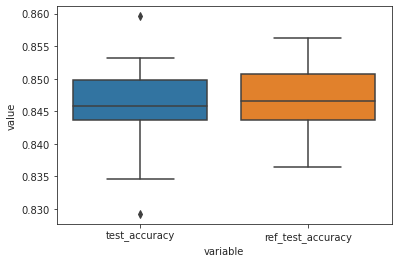

In [25]:
sns.boxplot(data=total_log[["test_accuracy", "ref_test_accuracy"]].melt(), x="variable", y="value")

In [26]:
[(key, model.get_params()[key]) for key in param_update_funcs.keys()]

[('histgradientboostingclassifier__l2_regularization', 0.007079457843841376),
 ('histgradientboostingclassifier__learning_rate', 0.14125375446227553),
 ('histgradientboostingclassifier__max_leaf_nodes', 17),
 ('histgradientboostingclassifier__min_samples_leaf', 14)]

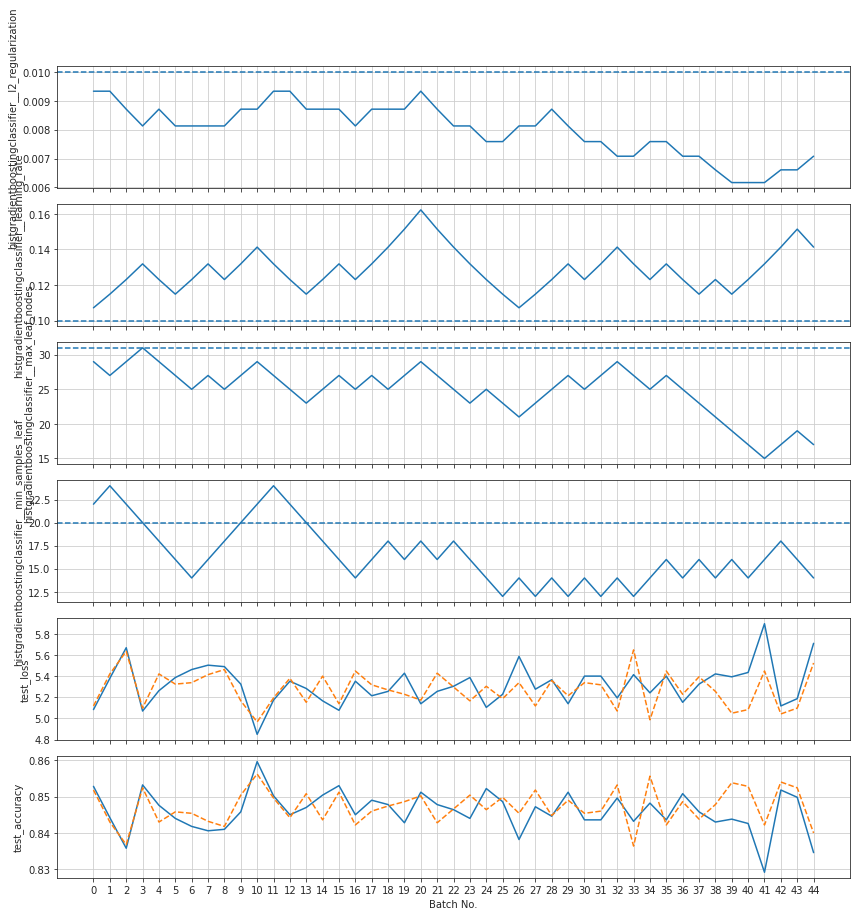

In [27]:
fig, axes = plt.subplots(6,1, figsize=(12, 12), sharex=True,
                         tight_layout=True,)
for idx, col in enumerate(total_log.columns[:-2]):
    axes[idx].plot(range(45), total_log[col])
    if (idx >3):
         axes[idx].plot(range(45), total_log.iloc[:, idx+2], ls="--")
    else:
        axes[idx].axhline(ref_model.get_params()[total_log.iloc[:, idx].name], ls="--")
    axes[idx].set_ylabel(col)
    axes[idx].grid(True)
axes[idx].set_xlabel("Batch No.")
axes[idx].set_xticks(range(45))
plt.show()